In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

In [10]:
def GetSet(file):
    set = open(file, 'r')
    lists = []
    lines = set.readlines()
    for i in range(len(lines)):
        line = lines[i].replace('[', '*')
        line = line.replace(']ns', '%')
        line = line.replace(']nt', '%')
        line = line.replace(']', '&')
        lists.append(line)
    set.close()
    return lists


def sigmoid(t):
    if t < -10:
        return 0
    elif t > 10:
        return 1
    return 1 / (1 + np.exp(-t))


def get_Ci_Val(Set):
    Ci = []
    Val = []
    for lines in Set:
        l = r = -1
        now = 0
        while 1:
            l = lines.find('*', r + 1)
            temp = lines[now: l].split()
            for item in temp:
                ci = item.split('/')
                if ci[0] in Vec:
                    Ci.append(Vec.index(ci[0]))
                elif ci[1][0] == 'w':
                    Ci.append(300)
                else:
                    Ci.append(1500)
                Val.append(int(ci[1] in ['ns', 'nt']))
            if l == -1:
                break
            r = lines.find('%', l + 1)
            if r == -1:
                break
            now = r + 1
            temp = lines[l+1: r].split()
            for item in temp:
                ci = item.split('/')
                if ci[0] in Vec:
                    Ci.append(Vec.index(ci[0]))
                elif ci[1][0] == 'w':
                    Ci.append(300)
                else:
                    Ci.append(1500)
                Val.append(1)
    return Ci, Val


def get_Ci_Val1(Set):
    Ci = []
    Val = []
    rate = 10
    for lines in Set:
        l = r = -1
        now = 0
        while 1:
            l = lines.find('*', r + 1)
            temp = lines[now: l].split()
            for item in temp:
                ci = item.split('/')
                if rate <= 0 and ci[1] not in ['ns', 'nt']:
                    continue
                if ci[1] not in ['ns', 'nt']:
                    rate -= 1
                else:
                    rate += 1
                if ci[0] in Vec:
                    Ci.append(Vec.index(ci[0]))
                elif ci[1][0] == 'w':
                    Ci.append(300)
                else:
                    Ci.append(1500)
                Val.append(int(ci[1] in ['ns', 'nt']))
            if l == -1:
                break
            r = lines.find('%', l + 1)
            if r == -1:
                break
            now = r + 1
            temp = lines[l+1: r].split()
            for item in temp:
                ci = item.split('/')
                rate += 1
                if ci[0] in Vec:
                    Ci.append(Vec.index(ci[0]))
                elif ci[1][0] == 'w':
                    Ci.append(300)
                else:
                    Ci.append(1500)
                Val.append(1)
    return Ci, Val


def func(predict, real):
    f1 = 0    # 正确预测数
    f2 = 0    # 模型预测总数
    f3 = 0    # 实体总数
    flag2 = 0
    flag3 = 0
    for i in range(len(predict)):
        if predict[i] == 1 and flag2 == 0:
            f2 += 1
            flag2 = 1
        elif predict[i] == 0:
            flag2 = 0
        if real[i] == 1 and flag3 == 0:
            f3 += 1
            flag3 = 1
        elif real[i] == 0:
            flag3 = 0
    i = 0
    length = len(real)
    while i < length:
        if real[i] == 1:
            l = i
            i += 1
            while i < length and real[i] == 1:
                i += 1
            r = i
            flag1 = 1
            for j in range(l, r):
                if predict[j] == 0:
                    flag1 = 0
                    break
            if flag1 == 1:
                if (l > 0 and predict[l-1] == 1) or (r < length and predict[r] == 1):
                    flag1 = 0
            if flag1 == 1:
                f1 += 1
        else:
            i += 1
    return f1, f2, f3


def cal_accuracy(Ci, Val, theta):
    predict = []
    for i in range(len(Ci)):
        temp = 0
        if i != 0:
            temp += theta[Ci[i-1]]
        temp += theta[Ci[i] + 1501]
        if i != len(Ci)-1:
            temp += theta[Ci[i+1] + 3002]
        res = sigmoid(temp)
        if res >= 0.9:
            predict.append(1)
        else:
            predict.append(0)
    f1, f2, f3 = func(predict, Val)
        
    print(f1, f2, f3)
    if f1 == 0 and f2 == 0 and f3 == 0:
        return 1
    elif f1 ==0 or f2 == 0 or f3 == 0:
        return 0
    else:
        return 2 * (f1 / f2) * (f1 / f3) / (f1 / f2 + f1 / f3)


In [3]:
file = open('词向量.txt')
trainSet = GetSet('训练集.txt')
verifySet = GetSet('验证集.txt')
testSet = GetSet('测试集.txt')

In [4]:
# 提取词向量
Vec = []

lines = file.readlines()
for item in lines:
    Vec.append(item[: -1])
    if len(Vec) >= 1500:
        break

In [5]:
# 提取Ci, Val

Ci_train, Val_train = get_Ci_Val1(trainSet)
Ci_trainSet, Val_trainSet = get_Ci_Val(trainSet)
Ci_verifySet, Val_verifySet = get_Ci_Val(verifySet)
Ci_testSet, Val_testSet = get_Ci_Val(testSet)


In [6]:
print(len(Ci_train))
print(len(Val_train))


66052
66052


In [11]:
theta = np.random.randn(4503, 1)
accuracy1 = []
accuracy2 = []
accuracy3 = []

for batch_size in range(10000):   
    grad = np.zeros(4503)
    l = len(Ci_train)
    for i in range(l):
        temp = 0
        if i != 0:
            temp += theta[Ci_train[i-1]]
        temp += theta[Ci_train[i] + 1501]
        if i != l-1:
            temp += theta[Ci_train[i+1] + 3002]
        temp = Val_train[i] - sigmoid(temp)
        if i != 0:
            grad[Ci_train[i-1]] += temp * 0.0002
        grad[Ci_train[i] + 1501] += temp * 0.0002
        if i != l-1:
            grad[Ci_train[i+1] + 3002] += temp * 0.0002
    grad = np.transpose([grad])
    theta = theta + grad
    print(np.transpose(theta))
    if batch_size % 10 == 0:
        a = cal_accuracy(Ci_trainSet, Val_trainSet, theta)
        accuracy1.append(a)
        b = cal_accuracy(Ci_verifySet, Val_verifySet, theta)
        accuracy2.append(b)
        c = cal_accuracy(Ci_testSet, Val_testSet, theta)
        accuracy3.append(c)
        print(a, b, c)

[[ 0.5834276  -0.73458673  1.29931942 ... -0.71913223  0.39784317
   0.21071454]]
859 47933 19290
258 16489 6670
172 9370 4707
0.02555672909569641 0.022280754782158123 0.024437024934289973
[[ 0.47149271 -0.73326094  1.2856152  ... -0.71939511  0.39749196
   0.51281397]]
[[ 0.36519247 -0.73492993  1.27117503 ... -0.71963052  0.39715681
   0.55841958]]
[[ 0.27581049 -0.73533061  1.25694733 ... -0.71983207  0.39684945
   0.6362915 ]]
[[ 0.19874718 -0.73547287  1.24282287 ... -0.72003257  0.39655168
   0.64273186]]
[[ 0.13451363 -0.73436389  1.22899679 ... -0.72022887  0.39626576
   0.65776026]]
[[ 0.08015025 -0.7324594   1.21541916 ... -0.72042838  0.39598639
   0.65466646]]
[[ 0.03453467 -0.72963402  1.20212943 ... -0.72062935  0.39571386
   0.65429309]]
[[-0.00403689 -0.72610565  1.18910703 ... -0.72083301  0.39544653
   0.65000192]]
[[-0.03659684 -0.72192528  1.17635589 ... -0.72103846  0.39518416
   0.64681258]]
[[-0.06416502 -0.71721131  1.16386601 ... -0.7212456   0.39492604
   0.64

[[-0.07750303 -0.20762409  0.67661025 ... -0.73502903  0.37789709
   0.59955996]]
[[-0.0764257  -0.20296029  0.67388621 ... -0.7351604   0.37769256
   0.59933171]]
4230 32268 19290
1278 10919 6670
886 6308 4707
0.1640870475968812 0.14531809653760874 0.16087153881071267
[[-0.07536998 -0.19834456  0.67120379 ... -0.73529079  0.37748812
   0.59910595]]
[[-0.07433529 -0.19377641  0.66856212 ... -0.7354202   0.37728376
   0.59888264]]
[[-0.07332109 -0.18925534  0.66596032 ... -0.73554864  0.37707948
   0.59866177]]
[[-0.07232683 -0.18478084  0.66339758 ... -0.73567611  0.37687528
   0.59844332]]
[[-0.07135198 -0.18035242  0.66087308 ... -0.73580262  0.37667115
   0.59822726]]
[[-0.07039604 -0.17596958  0.65838603 ... -0.73592817  0.3764671
   0.59801356]]
[[-0.06945849 -0.17163182  0.65593565 ... -0.73605276  0.37626312
   0.5978022 ]]
[[-0.06853886 -0.16733864  0.65352121 ... -0.73617641  0.37605922
   0.59759314]]
[[-0.06763668 -0.16308956  0.65114197 ... -0.73629911  0.37585538
   0.5973

[[-0.02699911  0.06983173  0.53439733 ... -0.74338266  0.35990067
   0.58600036]]
[[-0.02669209  0.07185342  0.53349676 ... -0.74344358  0.35970002
   0.5858961 ]]
[[-0.02638771  0.07385914  0.53260543 ... -0.74350387  0.35949939
   0.58579243]]
5466 31404 19290
1709 10575 6670
1206 6265 4707
0.21564682210912534 0.19820237750072486 0.2198323004010208
[[-0.02608593  0.0758491   0.53172323 ... -0.74356354  0.3592988
   0.58568934]]
[[-0.0257867   0.07782348  0.53085002 ... -0.7436226   0.35909822
   0.58558684]]
[[-0.02548997  0.07978248  0.5299857  ... -0.74368104  0.35889767
   0.5854849 ]]
[[-0.02519569  0.08172629  0.52913015 ... -0.74373887  0.35869714
   0.58538353]]
[[-0.02490381  0.08365509  0.52828325 ... -0.7437961   0.35849664
   0.5852827 ]]
[[-0.0246143   0.08556907  0.52744489 ... -0.74385272  0.35829616
   0.58518241]]
[[-0.0243271   0.08746841  0.52661495 ... -0.74390874  0.3580957
   0.58508266]]
[[-0.02404218  0.08935328  0.52579333 ... -0.74396416  0.35789526
   0.5849

[[-0.00628464  0.20423961  0.48027049 ... -0.74667927  0.34212543
   0.57834066]]
[[-0.00610004  0.20537527  0.47987469 ... -0.74669513  0.34192657
   0.57826781]]
[[-0.00591614  0.20650506  0.47948219 ... -0.74671059  0.34172772
   0.57819518]]
[[-0.00573291  0.20762904  0.47909295 ... -0.74672564  0.34152889
   0.57812277]]
6279 30254 19290
2031 10107 6670
1436 6087 4707
0.25347166155336676 0.24211718424032905 0.26607374467296646
[[-0.00555036  0.20874727  0.47870695 ... -0.74674029  0.34133007
   0.57805057]]
[[-0.00536848  0.2098598   0.47832416 ... -0.74675453  0.34113128
   0.57797858]]
[[-0.00518726  0.2109667   0.47794453 ... -0.74676838  0.3409325
   0.57790681]]
[[-0.00500669  0.212068    0.47756804 ... -0.74678183  0.34073374
   0.57783524]]
[[-0.00482677  0.21316378  0.47719466 ... -0.74679488  0.340535
   0.57776389]]
[[-0.0046475   0.21425408  0.47682436 ... -0.74680754  0.34033628
   0.57769274]]
[[-0.00446885  0.21533895  0.4764571  ... -0.74681981  0.34013757
   0.5776

[[ 0.00758326  0.28508316  0.4555749  ... -0.74672365  0.32508848
   0.5727597 ]]
[[ 0.0077249   0.28586661  0.45537273 ... -0.74671026  0.32489116
   0.57270194]]
[[ 0.00786616  0.28664725  0.45517203 ... -0.74669658  0.32469387
   0.57264431]]
[[ 0.00800704  0.2874251   0.45497278 ... -0.74668262  0.32449659
   0.57258684]]
[[ 0.00814754  0.28820018  0.45477498 ... -0.74666838  0.32429933
   0.5725295 ]]
[[ 0.00828766  0.2889725   0.45457861 ... -0.74665386  0.3241021
   0.57247231]]
[[ 0.00842741  0.2897421   0.45438366 ... -0.74663907  0.32390488
   0.57241527]]
[[ 0.00856678  0.29050898  0.45419011 ... -0.74662399  0.32370767
   0.57235837]]
7004 29477 19290
2287 9917 6670
1650 6013 4707
0.28724342280640597 0.27575812383191656 0.3078358208955224
[[ 0.00870577  0.29127316  0.45399797 ... -0.74660865  0.32351049
   0.57230161]]
[[ 0.0088444   0.29203468  0.4538072  ... -0.74659302  0.32331333
   0.57224499]]
[[ 0.00898266  0.29279354  0.4536178  ... -0.74657712  0.32311618
   0.5721

[[ 0.01883784  0.34567603  0.44214146 ... -0.74453948  0.30760283
   0.56814013]]
[[ 0.01895017  0.34626969  0.44203148 ... -0.74450473  0.30740726
   0.56809371]]
[[ 0.01906221  0.34686173  0.44192219 ... -0.74446979  0.3072117
   0.5680474 ]]
[[ 0.01917397  0.34745218  0.44181359 ... -0.74443465  0.30701617
   0.56800121]]
[[ 0.01928545  0.34804103  0.44170569 ... -0.7443993   0.30682066
   0.56795512]]
[[ 0.01939664  0.34862829  0.44159847 ... -0.74436375  0.30662517
   0.56790915]]
[[ 0.01950754  0.34921398  0.44149192 ... -0.74432801  0.30642969
   0.56786329]]
[[ 0.01961817  0.3497981   0.44138605 ... -0.74429206  0.30623424
   0.56781754]]
[[ 0.01972851  0.35038065  0.44128085 ... -0.74425592  0.30603881
   0.56777189]]
7526 28380 19290
2462 9571 6670
1761 5870 4707
0.3157541430669184 0.30318330152084233 0.3329866691878604
[[ 0.01983857  0.35096166  0.44117631 ... -0.74421958  0.3058434
   0.56772636]]
[[ 0.01994835  0.35154112  0.44107242 ... -0.74418304  0.30564801
   0.567680

[[ 0.02779539  0.39302698  0.43456458 ... -0.7407288   0.29027948
   0.56441213]]
[[ 0.027885    0.39350421  0.43449969 ... -0.74067851  0.29008581
   0.56437451]]
[[ 0.02797438  0.39398038  0.43443516 ... -0.74062807  0.28989217
   0.56433697]]
[[ 0.02806355  0.39445549  0.43437099 ... -0.74057748  0.28969855
   0.56429952]]
[[ 0.02815248  0.39492954  0.43430715 ... -0.74052674  0.28950495
   0.56426215]]
[[ 0.0282412   0.39540256  0.43424367 ... -0.74047585  0.28931137
   0.56422487]]
[[ 0.02832969  0.39587452  0.43418052 ... -0.74042481  0.28911782
   0.56418768]]
[[ 0.02841795  0.39634546  0.43411772 ... -0.74037363  0.28892429
   0.56415057]]
[[ 0.028506    0.39681535  0.43405526 ... -0.7403223   0.28873078
   0.56411355]]
[[ 0.02859383  0.39728422  0.43399313 ... -0.74027082  0.28853729
   0.56407661]]
7928 28168 19290
2615 9467 6670
1897 5859 4707
0.33410594631042184 0.32409989465204186 0.3590762824152944
[[ 0.02868143  0.39775206  0.43393133 ... -0.74021919  0.28834382
   0.564

8272 27780 19290
2730 9262 6670
1951 5789 4707
0.35147652432547266 0.34270650263620384 0.3717606707317073
[[ 0.03502591  0.43218476  0.42987877 ... -0.73565319  0.27294095
   0.5613469 ]]
[[ 0.03509753  0.43258138  0.42983726 ... -0.7355911   0.27274936
   0.5613162 ]]
[[ 0.03516897  0.43297723  0.42979594 ... -0.73552889  0.27255779
   0.56128556]]
[[ 0.03524024  0.43337234  0.42975481 ... -0.73546657  0.27236625
   0.56125499]]
[[ 0.03531133  0.4337667   0.42971385 ... -0.73540414  0.27217473
   0.56122449]]
[[ 0.03538225  0.4341603   0.42967307 ... -0.7353416   0.27198323
   0.56119406]]
[[ 0.035453    0.43455317  0.42963248 ... -0.73527894  0.27179176
   0.5611637 ]]
[[ 0.03552357  0.43494529  0.42959206 ... -0.73521617  0.27160032
   0.5611334 ]]
[[ 0.03559397  0.43533667  0.42955182 ... -0.73515329  0.27140889
   0.56110316]]
[[ 0.0356642   0.43572732  0.42951175 ... -0.7350903   0.27121749
   0.561073  ]]
8308 27730 19290
2736 9236 6670
1963 5776 4707
0.35338153977031045 0.34402

[[ 0.04076645  0.46479245  0.42678106 ... -0.7297158   0.25598403
   0.55885954]]
8586 27808 19290
2818 9266 6670
2014 5797 4707
0.3646014692768271 0.3536646586345381 0.3834729626808835
[[ 0.04082427  0.4651307   0.42675185 ... -0.72964474  0.2557946
   0.5588342 ]]
[[ 0.04088195  0.46546839  0.42672274 ... -0.72957359  0.2556052
   0.5588089 ]]
[[ 0.04093949  0.46580552  0.42669373 ... -0.72950235  0.25541583
   0.55878366]]
[[ 0.0409969   0.46614208  0.42666482 ... -0.72943103  0.25522648
   0.55875848]]
[[ 0.04105418  0.46647808  0.426636   ... -0.72935961  0.25503715
   0.55873334]]
[[ 0.04111132  0.46681351  0.42660729 ... -0.72928811  0.25484785
   0.55870826]]
[[ 0.04116832  0.46714839  0.42657867 ... -0.72921652  0.25465858
   0.55868323]]
[[ 0.0412252   0.46748271  0.42655015 ... -0.72914484  0.25446933
   0.55865826]]
[[ 0.04128194  0.46781647  0.42652172 ... -0.72907308  0.2542801
   0.55863333]]
[[ 0.04133854  0.46814968  0.42649339 ... -0.72900123  0.2540909
   0.55860846]

[[ 0.04542201  0.49285004  0.42450855 ... -0.72306926  0.23922362
   0.5567974 ]]
[[ 0.04546915  0.49314365  0.42448612 ... -0.72299115  0.23903644
   0.5567763 ]]
8898 27640 19290
2897 9233 6670
2056 5751 4707
0.37920306839974427 0.364333773501855 0.39319181487856186
[[ 0.04551619  0.49343682  0.42446374 ... -0.72291298  0.23884929
   0.55675523]]
[[ 0.04556312  0.49372955  0.42444142 ... -0.72283473  0.23866216
   0.55673421]]
[[ 0.04560995  0.49402184  0.42441916 ... -0.72275641  0.23847506
   0.55671323]]
[[ 0.04565667  0.4943137   0.42439695 ... -0.72267803  0.23828799
   0.55669229]]
[[ 0.04570328  0.49460511  0.42437479 ... -0.72259957  0.23810094
   0.5566714 ]]
[[ 0.0457498   0.49489609  0.42435269 ... -0.72252105  0.23791392
   0.55665054]]
[[ 0.04579621  0.49518664  0.42433065 ... -0.72244245  0.23772692
   0.55662973]]
[[ 0.04584252  0.49547675  0.42430865 ... -0.72236379  0.23753995
   0.55660896]]
[[ 0.04588872  0.49576643  0.42428672 ... -0.72228506  0.237353
   0.556588

[[ 0.04923797  0.51737479  0.42269702 ... -0.7158614   0.22266593
   0.55507394]]
[[ 0.04927683  0.51763322  0.42267843 ... -0.71577767  0.22248106
   0.55505624]]
[[ 0.04931562  0.5178913   0.42265988 ... -0.71569388  0.22229621
   0.55503857]]
9219 27518 19290
3013 9187 6670
2116 5729 4707
0.3939070244402666 0.3800214416346094 0.40551935607512457
[[ 0.04935432  0.51814902  0.42264136 ... -0.71561004  0.22211139
   0.55502093]]
[[ 0.04939294  0.5184064   0.42262287 ... -0.71552615  0.2219266
   0.55500333]]
[[ 0.04943148  0.51866342  0.42260442 ... -0.7154422   0.22174183
   0.55498576]]
[[ 0.04946994  0.5189201   0.42258599 ... -0.71535819  0.22155709
   0.55496822]]
[[ 0.04950832  0.51917643  0.4225676  ... -0.71527412  0.22137238
   0.55495072]]
[[ 0.04954662  0.51943241  0.42254923 ... -0.71519     0.22118769
   0.55493325]]
[[ 0.04958484  0.51968804  0.4225309  ... -0.71510583  0.22100302
   0.55491582]]
[[ 0.04962298  0.51994333  0.4225126  ... -0.7150216   0.22081839
   0.55489

[[ 0.05240149  0.53908394  0.42115037 ... -0.70820271  0.20631526
   0.55362391]]
[[ 0.0524339   0.53931401  0.42113402 ... -0.70811444  0.20613274
   0.55360897]]
[[ 0.05246625  0.53954378  0.4211177  ... -0.70802612  0.20595024
   0.55359405]]
[[ 0.05249854  0.53977328  0.4211014  ... -0.70793776  0.20576776
   0.55357917]]
9392 27407 19290
3057 9147 6670
2156 5701 4707
0.4022528213803884 0.38654612126193333 0.4142966948501153
[[ 0.05253076  0.54000248  0.42108511 ... -0.70784935  0.20558531
   0.55356431]]
[[ 0.05256292  0.5402314   0.42106885 ... -0.70776089  0.20540289
   0.55354949]]
[[ 0.05259502  0.54046004  0.4210526  ... -0.70767239  0.2052205
   0.55353469]]
[[ 0.05262705  0.54068839  0.42103637 ... -0.70758384  0.20503813
   0.55351991]]
[[ 0.05265902  0.54091646  0.42102016 ... -0.70749525  0.20485579
   0.55350517]]
[[ 0.05269093  0.54114424  0.42100397 ... -0.70740662  0.20467347
   0.55349045]]
[[ 0.05272278  0.54137175  0.4209878  ... -0.70731793  0.20449118
   0.55347

[[ 0.05505421  0.55850206  0.41976001 ... -0.7001776   0.19017442
   0.55239758]]
[[ 0.05508155  0.55870882  0.41974502 ... -0.70008561  0.18999426
   0.55238492]]
[[ 0.05510884  0.55891535  0.41973003 ... -0.69999359  0.18981413
   0.55237228]]
[[ 0.05513607  0.55912164  0.41971505 ... -0.69990153  0.18963403
   0.55235966]]
[[ 0.05516326  0.55932769  0.41970009 ... -0.69980943  0.18945395
   0.55234707]]
9585 27411 19290
3121 9169 6670
2199 5727 4707
0.4104837155521295 0.39409053601868804 0.42150661299597464
[[ 0.0551904   0.55953351  0.41968514 ... -0.69971729  0.1892739
   0.5523345 ]]
[[ 0.05521749  0.55973909  0.4196702  ... -0.69962511  0.18909387
   0.55232195]]
[[ 0.05524452  0.55994443  0.41965527 ... -0.6995329   0.18891387
   0.55230942]]
[[ 0.05527151  0.56014954  0.41964035 ... -0.69944065  0.1887339
   0.55229692]]
[[ 0.05529845  0.56035441  0.41962544 ... -0.69934837  0.18855396
   0.55228444]]
[[ 0.05532534  0.56055905  0.41961055 ... -0.69925604  0.18837404
   0.55227

[[ 0.0573033   0.57602352  0.41846446 ... -0.69185172  0.174245
   0.55135646]]
[[ 0.05732661  0.57621084  0.41845029 ... -0.69175667  0.17406722
   0.55134569]]
[[ 0.05734988  0.57639796  0.41843612 ... -0.69166159  0.17388947
   0.55133494]]
[[ 0.05737311  0.57658488  0.41842197 ... -0.69156648  0.17371174
   0.5513242 ]]
[[ 0.05739629  0.5767716   0.41840782 ... -0.69147134  0.17353405
   0.55131349]]
[[ 0.05741944  0.57695812  0.41839368 ... -0.69137616  0.17335638
   0.5513028 ]]
9733 27339 19290
3164 9157 6670
2240 5738 4707
0.4174655257457805 0.39982308712958864 0.42891335567257066
[[ 0.05744255  0.57714444  0.41837955 ... -0.69128096  0.17317873
   0.55129212]]
[[ 0.05746562  0.57733057  0.41836542 ... -0.69118572  0.17300111
   0.55128147]]
[[ 0.05748865  0.57751649  0.4183513  ... -0.69109046  0.17282352
   0.55127084]]
[[ 0.05751164  0.57770222  0.41833719 ... -0.69099516  0.17264596
   0.55126022]]
[[ 0.05753458  0.57788776  0.41832308 ... -0.69089983  0.17246842
   0.55124

[[ 0.05923038  0.59195159  0.41722842 ... -0.68327702  0.15852762
   0.55047026]]
[[ 0.05925045  0.59212246  0.41721478 ... -0.68317943  0.15835222
   0.55046109]]
[[ 0.0592705   0.59229316  0.41720115 ... -0.68308181  0.15817686
   0.55045193]]
[[ 0.05929051  0.59246369  0.41718753 ... -0.68298417  0.15800151
   0.55044279]]
[[ 0.05931049  0.59263405  0.4171739  ... -0.6828865   0.1578262
   0.55043367]]
[[ 0.05933043  0.59280424  0.41716029 ... -0.68278881  0.15765091
   0.55042456]]
[[ 0.05935035  0.59297426  0.41714667 ... -0.68269108  0.15747565
   0.55041547]]
9874 27345 19290
3205 9175 6670
2272 5737 4707
0.423458775597727 0.40454402019564534 0.43508234392952894
[[ 0.05937023  0.59314412  0.41713307 ... -0.68259334  0.15730041
   0.5504064 ]]
[[ 0.05939008  0.5933138   0.41711946 ... -0.68249556  0.15712521
   0.55039734]]
[[ 0.0594099   0.59348332  0.41710586 ... -0.68239777  0.15695003
   0.55038829]]
[[ 0.05942968  0.59365267  0.41709227 ... -0.68229994  0.15677487
   0.55037

[[ 0.06089794  0.60652389  0.4160318  ... -0.67449519  0.14302214
   0.54971497]]
[[ 0.06091539  0.60668068  0.41601853 ... -0.67439547  0.14284912
   0.54970714]]
[[ 0.06093282  0.60683733  0.41600527 ... -0.67429574  0.14267613
   0.54969934]]
[[ 0.06095023  0.60699382  0.415992   ... -0.67419598  0.14250317
   0.54969155]]
[[ 0.06096761  0.60715017  0.41597875 ... -0.6740962   0.14233023
   0.54968377]]
[[ 0.06098496  0.60730638  0.41596549 ... -0.6739964   0.14215732
   0.549676  ]]
[[ 0.06100228  0.60746244  0.41595224 ... -0.67389658  0.14198443
   0.54966825]]
[[ 0.06101958  0.60761835  0.41593899 ... -0.67379673  0.14181158
   0.54966051]]
10054 27305 19290
3247 9155 6670
2307 5712 4707
0.43154844940444254 0.41036334913112166 0.4428448027641808
[[ 0.06103685  0.60777412  0.41592574 ... -0.67369687  0.14163875
   0.54965279]]
[[ 0.0610541   0.60792974  0.4159125  ... -0.67359698  0.14146594
   0.54964508]]
[[ 0.06107132  0.60808522  0.41589926 ... -0.67349707  0.14129316
   0.54

[[ 0.06235422  0.61992965  0.4148635  ... -0.6655401   0.12772779
   0.54907111]]
[[ 0.06236953  0.62007427  0.4148505  ... -0.6654386   0.12755714
   0.54906444]]
[[ 0.06238482  0.62021875  0.41483752 ... -0.66533709  0.12738652
   0.54905779]]
[[ 0.0624001   0.62036311  0.41482453 ... -0.66523556  0.12721592
   0.54905115]]
[[ 0.06241535  0.6205075   0.41481155 ... -0.66513402  0.12704535
   0.54904452]]
[[ 0.06243058  0.62065176  0.41479857 ... -0.66503245  0.1268748
   0.5490379 ]]
[[ 0.06244578  0.6207959   0.41478559 ... -0.66493087  0.12670428
   0.5490313 ]]
[[ 0.06246097  0.6209399   0.41477262 ... -0.66482927  0.12653379
   0.54902471]]
[[ 0.06247613  0.62108378  0.41475964 ... -0.66472765  0.12636332
   0.54901812]]
10205 27355 19290
3281 9159 6670
2338 5738 4707
0.4375602958516454 0.4145555625750205 0.4476783149832456
[[ 0.06249127  0.62122753  0.41474668 ... -0.66462601  0.12619288
   0.54901155]]
[[ 0.0625064   0.62137115  0.41473371 ... -0.66452436  0.12602247
   0.54900

[[ 0.0636372   0.63233024  0.41371792 ... -0.65643962  0.11264332
   0.54852278]]
[[ 0.06365075  0.63246427  0.41370517 ... -0.65633663  0.11247501
   0.54851711]]
[[ 0.06366428  0.63259818  0.41369241 ... -0.65623363  0.11230674
   0.54851144]]
[[ 0.0636778   0.63273199  0.41367967 ... -0.65613061  0.11213849
   0.54850579]]
[[ 0.0636913   0.63286568  0.41366692 ... -0.65602758  0.11197027
   0.54850015]]
[[ 0.06370477  0.63299927  0.41365418 ... -0.65592453  0.11180207
   0.54849452]]
[[ 0.06371824  0.63313274  0.41364144 ... -0.65582147  0.1116339
   0.54848891]]
[[ 0.06373168  0.63326609  0.4136287  ... -0.65571839  0.11146575
   0.5484833 ]]
[[ 0.06374511  0.63339934  0.41361597 ... -0.6556153   0.11129763
   0.5484777 ]]
[[ 0.06375851  0.63353248  0.41360323 ... -0.65551219  0.11112954
   0.54847211]]
10316 27335 19290
3306 9132 6670
2368 5744 4707
0.4425093833780161 0.4184280470826478 0.45316237680604726
[[ 0.0637719   0.6336655   0.4135905  ... -0.65540906  0.11096148
   0.5484

10414 27404 19290
3343 9160 6670
2394 5764 4707
0.44605302608472175 0.42236260265319014 0.45726291662687424
[[ 0.06478864  0.64396145  0.41258037 ... -0.64711266  0.09760106
   0.54805231]]
[[ 0.06480071  0.64408599  0.41256785 ... -0.6470084   0.09743511
   0.54804751]]
[[ 0.06481276  0.64421043  0.41255533 ... -0.64690413  0.09726919
   0.54804273]]
[[ 0.06482479  0.64433477  0.41254281 ... -0.64679985  0.0971033
   0.54803795]]
[[ 0.06483682  0.64445902  0.4125303  ... -0.64669555  0.09693743
   0.54803318]]
[[ 0.06484882  0.64458317  0.41251779 ... -0.64659125  0.09677158
   0.54802842]]
[[ 0.06486081  0.64470721  0.41250528 ... -0.64648693  0.09660576
   0.54802367]]
[[ 0.06487279  0.64483116  0.41249277 ... -0.64638259  0.09643997
   0.54801893]]
[[ 0.06488475  0.64495502  0.41248026 ... -0.64627825  0.09627421
   0.54801419]]
[[ 0.0648967   0.64507877  0.41246776 ... -0.64617389  0.09610847
   0.54800947]]
10425 27417 19290
3344 9158 6670
2396 5762 4707
0.44639989723167833 0.422

[[ 0.06580685  0.6546737   0.41147606 ... -0.63778606  0.08293328
   0.54765933]]
10522 27423 19290
3369 9167 6670
2411 5781 4707
0.45049557938903523 0.42545936730441375 0.4597635392829901
[[ 0.06581769  0.65478996  0.41146377 ... -0.63768075  0.08276964
   0.54765529]]
[[ 0.06582851  0.65490612  0.41145148 ... -0.63757543  0.08260602
   0.54765125]]
[[ 0.06583932  0.6550222   0.4114392  ... -0.63747009  0.08244243
   0.54764722]]
[[ 0.06585012  0.6551382   0.41142692 ... -0.63736475  0.08227886
   0.5476432 ]]
[[ 0.06586091  0.6552541   0.41141464 ... -0.63725939  0.08211532
   0.54763919]]
[[ 0.06587168  0.65536992  0.41140237 ... -0.63715403  0.08195181
   0.54763519]]
[[ 0.06588245  0.65548565  0.41139009 ... -0.63704865  0.08178832
   0.54763119]]
[[ 0.06589319  0.6556013   0.41137782 ... -0.63694327  0.08162486
   0.5476272 ]]
[[ 0.06590393  0.65571685  0.41136556 ... -0.63683787  0.08146142
   0.54762322]]
[[ 0.06591465  0.65583232  0.41135329 ... -0.63673246  0.08129801
   0.54

[[ 0.06672439  0.66468954  0.41039329 ... -0.62837322  0.06846943
   0.54732913]]
[[ 0.06673419  0.66479841  0.41038126 ... -0.62826703  0.06830806
   0.54732575]]
10600 27462 19290
3386 9185 6670
2427 5789 4707
0.4534565366187543 0.4271207820876695 0.4624618902439024
[[ 0.06674397  0.66490721  0.41036922 ... -0.62816082  0.06814672
   0.54732237]]
[[ 0.06675375  0.66501593  0.41035719 ... -0.62805461  0.06798541
   0.547319  ]]
[[ 0.06676352  0.66512456  0.41034516 ... -0.62794838  0.06782412
   0.54731564]]
[[ 0.06677327  0.66523313  0.41033314 ... -0.62784215  0.06766286
   0.54731229]]
[[ 0.06678302  0.66534161  0.41032111 ... -0.62773591  0.06750162
   0.54730894]]
[[ 0.06679275  0.66545002  0.41030909 ... -0.62762966  0.0673404
   0.5473056 ]]
[[ 0.06680248  0.66555834  0.41029708 ... -0.6275234   0.06717922
   0.54730226]]
[[ 0.06681219  0.6656666   0.41028506 ... -0.62741713  0.06701805
   0.54729893]]
[[ 0.06682189  0.66577477  0.41027305 ... -0.62731085  0.06685692
   0.54729

[[ 0.06755654  0.67408301  0.40933377 ... -0.61888812  0.05420704
   0.54705418]]
[[ 0.06756545  0.67418527  0.40932201 ... -0.61878118  0.05404792
   0.54705138]]
[[ 0.06757436  0.67428746  0.40931024 ... -0.61867424  0.05388883
   0.54704859]]
10684 27511 19290
3427 9219 6670
2455 5814 4707
0.4565714407811799 0.4313676128138964 0.4666856762665146
[[ 0.06758325  0.67438957  0.40929848 ... -0.61856729  0.05372976
   0.5470458 ]]
[[ 0.06759214  0.67449162  0.40928673 ... -0.61846032  0.05357072
   0.54704301]]
[[ 0.06760102  0.67459359  0.40927497 ... -0.61835336  0.0534117
   0.54704024]]
[[ 0.06760989  0.6746955   0.40926323 ... -0.61824638  0.05325271
   0.54703747]]
[[ 0.06761875  0.67479734  0.40925148 ... -0.6181394   0.05309375
   0.5470347 ]]
[[ 0.0676276   0.6748991   0.40923974 ... -0.61803241  0.0529348
   0.54703195]]
[[ 0.06763644  0.6750008   0.409228   ... -0.61792541  0.05277589
   0.5470292 ]]
[[ 0.06764527  0.67510243  0.40921626 ... -0.61781841  0.052617
   0.54702645

[[ 0.06831575  0.68291703  0.40829936 ... -0.60934274  0.04014348
   0.54682803]]
[[ 0.06832391  0.68301332  0.40828789 ... -0.60923519  0.03998658
   0.54682575]]
[[ 0.06833206  0.68310955  0.40827642 ... -0.60912763  0.03982971
   0.54682347]]
[[ 0.0683402   0.68320572  0.40826496 ... -0.60902006  0.03967286
   0.5468212 ]]
10862 27523 19290
3522 9214 6670
2466 5791 4707
0.46405912887445794 0.4434651221354822 0.46980377214707564
[[ 0.06834833  0.68330182  0.40825349 ... -0.60891249  0.03951604
   0.54681893]]
[[ 0.06835646  0.68339786  0.40824204 ... -0.60880491  0.03935924
   0.54681667]]
[[ 0.06836457  0.68349383  0.40823058 ... -0.60869733  0.03920246
   0.54681441]]
[[ 0.06837268  0.68358974  0.40821913 ... -0.60858974  0.03904571
   0.54681216]]
[[ 0.06838078  0.68368559  0.40820768 ... -0.60848214  0.03888899
   0.54680991]]
[[ 0.06838888  0.68378138  0.40819623 ... -0.60837454  0.03873229
   0.54680767]]
[[ 0.06839696  0.6838771   0.40818479 ... -0.60826693  0.03857561
   0.54

[[ 0.06901219  0.69124554  0.40729193 ... -0.59974744  0.02627601
   0.54664539]]
[[ 0.06901969  0.69133643  0.40728077 ... -0.59963938  0.0261213
   0.54664357]]
[[ 0.06902719  0.69142726  0.40726962 ... -0.59953131  0.02596662
   0.54664175]]
[[ 0.06903467  0.69151803  0.40725847 ... -0.59942324  0.02581195
   0.54663994]]
[[ 0.06904216  0.69160875  0.40724732 ... -0.59931516  0.02565732
   0.54663813]]
10922 27555 19290
3532 9241 6670
2488 5819 4707
0.4663037677446899 0.4439695807931619 0.47273418202546075
[[ 0.06904963  0.69169941  0.40723617 ... -0.59920708  0.0255027
   0.54663633]]
[[ 0.0690571   0.69179001  0.40722503 ... -0.599099    0.02534811
   0.54663453]]
[[ 0.06906456  0.69188056  0.40721389 ... -0.59899091  0.02519355
   0.54663273]]
[[ 0.06907201  0.69197105  0.40720276 ... -0.59888281  0.02503901
   0.54663095]]
[[ 0.06907946  0.69206148  0.40719163 ... -0.59877471  0.02488449
   0.54662916]]
[[ 0.0690869   0.69215185  0.4071805  ... -0.5986666   0.02473
   0.54662738

[[ 0.06965425  0.69911524  0.40631316 ... -0.59011122  0.01260179
   0.54650162]]
[[ 0.06966118  0.69920121  0.40630233 ... -0.59000274  0.01244923
   0.54650021]]
[[ 0.06966811  0.69928714  0.40629151 ... -0.58989426  0.0122967
   0.54649881]]
[[ 0.06967503  0.69937301  0.40628069 ... -0.58978578  0.01214419
   0.54649741]]
[[ 0.06968194  0.69945883  0.40626987 ... -0.5896773   0.01199171
   0.54649601]]
[[ 0.06968885  0.6995446   0.40625905 ... -0.58956881  0.01183925
   0.54649462]]
11009 27632 19290
3551 9247 6670
2516 5842 4707
0.4692468351732662 0.44618960859458434 0.47701203905583467
[[ 0.06969576  0.69963031  0.40624824 ... -0.58946031  0.01168681
   0.54649323]]
[[ 0.06970265  0.69971597  0.40623744 ... -0.58935181  0.0115344
   0.54649184]]
[[ 0.06970955  0.69980158  0.40622664 ... -0.58924331  0.01138201
   0.54649046]]
[[ 0.06971643  0.69988714  0.40621584 ... -0.5891348   0.01122965
   0.54648909]]
[[ 0.06972331  0.69997264  0.40620504 ... -0.58902629  0.01107731
   0.5464

[[ 7.02360219e-02  7.06403700e-01  4.05385448e-01 ... -5.80659538e-01
  -5.81176845e-04  5.46394793e-01]]
[[ 0.07024247  0.70648529  0.40537496 ... -0.58055074 -0.00073166
   0.54639375]]
[[ 0.07024891  0.70656683  0.40536447 ... -0.58044194 -0.00088212
   0.5463927 ]]
[[ 0.07025534  0.70664832  0.40535398 ... -0.58033314 -0.00103255
   0.54639166]]
[[ 0.07026177  0.70672976  0.4053435  ... -0.58022433 -0.00118296
   0.54639063]]
[[ 0.0702682   0.70681115  0.40533303 ... -0.58011552 -0.00133335
   0.5463896 ]]
[[ 0.07027462  0.7068925   0.40532256 ... -0.5800067  -0.00148371
   0.54638857]]
[[ 0.07028103  0.7069738   0.40531209 ... -0.57989789 -0.00163405
   0.54638755]]
[[ 0.07028744  0.70705505  0.40530162 ... -0.57978907 -0.00178437
   0.54638653]]
11076 27730 19290
3579 9274 6670
2528 5864 4707
0.4711186729051468 0.4489463120923231 0.47828966039163745
[[ 0.07029385  0.70713625  0.40529116 ... -0.57968024 -0.00193466
   0.54638551]]
[[ 0.07030024  0.7072174   0.40528071 ... -0.57957

[[ 0.07078996  0.71348107  0.40446723 ... -0.57096463 -0.01388191
   0.54631658]]
[[ 0.07079597  0.71355854  0.40445709 ... -0.57085557 -0.0140303
   0.54631587]]
[[ 0.07080197  0.71363596  0.40444696 ... -0.57074652 -0.01417867
   0.54631516]]
[[ 0.07080797  0.71371334  0.40443683 ... -0.57063745 -0.01432702
   0.54631446]]
[[ 0.07081396  0.71379067  0.40442671 ... -0.57052839 -0.01447534
   0.54631376]]
[[ 0.07081995  0.71386796  0.40441659 ... -0.57041932 -0.01462364
   0.54631306]]
[[ 0.07082593  0.71394521  0.40440647 ... -0.57031025 -0.01477192
   0.54631237]]
[[ 0.07083191  0.71402241  0.40439636 ... -0.57020118 -0.01492017
   0.54631168]]
[[ 0.07083788  0.71409957  0.40438625 ... -0.57009211 -0.0150684
   0.54631099]]
[[ 0.07084385  0.71417669  0.40437615 ... -0.56998303 -0.01521661
   0.54631031]]
11149 27834 19290
3600 9298 6670
2545 5898 4707
0.47317714964773794 0.45090180360721444 0.4799622819424799
[[ 0.07084982  0.71425376  0.40436605 ... -0.56987395 -0.01536479
   0.5463

11213 27911 19290
3626 9337 6670
2566 5907 4707
0.47511705260481774 0.45305178984194416 0.48351234218956096
[[ 0.07131266  0.72028043  0.40357119 ... -0.56114029 -0.02714456
   0.54626644]]
[[ 0.07131827  0.72035407  0.40356142 ... -0.56103104 -0.02729088
   0.54626603]]
[[ 0.07132388  0.72042767  0.40355165 ... -0.56092178 -0.02743717
   0.54626563]]
[[ 0.07132948  0.72050122  0.40354189 ... -0.56081252 -0.02758344
   0.54626524]]
[[ 0.07133508  0.72057474  0.40353213 ... -0.56070326 -0.02772969
   0.54626484]]
[[ 0.07134068  0.72064822  0.40352238 ... -0.560594   -0.02787591
   0.54626445]]
[[ 0.07134627  0.72072166  0.40351263 ... -0.56048474 -0.02802211
   0.54626406]]
[[ 0.07135186  0.72079505  0.40350288 ... -0.56037548 -0.02816829
   0.54626368]]
[[ 0.07135744  0.72086841  0.40349314 ... -0.56026621 -0.02831445
   0.5462633 ]]
[[ 0.07136302  0.72094172  0.4034834  ... -0.56015694 -0.02846058
   0.54626292]]
11215 27942 19290
3628 9354 6670
2568 5916 4707
0.4748899051490515 0.452

[[ 0.07179659  0.72667882  0.4027177  ... -0.55141029 -0.04007747
   0.5462428 ]]
11280 28037 19290
3641 9362 6670
2576 5941 4707
0.4766834999049169 0.45421656686626743 0.4838467317806161
[[ 0.07180185  0.72674897  0.4027083  ... -0.5513009  -0.04022177
   0.54624267]]
[[ 0.07180711  0.72681909  0.4026989  ... -0.55119151 -0.04036604
   0.54624255]]
[[ 0.07181237  0.72688916  0.4026895  ... -0.55108211 -0.04051029
   0.54624243]]
[[ 0.07181763  0.7269592   0.40268011 ... -0.55097272 -0.04065452
   0.54624231]]
[[ 0.07182288  0.7270292   0.40267072 ... -0.55086332 -0.04079872
   0.54624219]]
[[ 0.07182812  0.72709917  0.40266134 ... -0.55075393 -0.0409429
   0.54624208]]
[[ 0.07183336  0.72716909  0.40265196 ... -0.55064453 -0.04108706
   0.54624197]]
[[ 0.0718386   0.72723898  0.40264258 ... -0.55053513 -0.0412312
   0.54624186]]
[[ 0.07184384  0.72730883  0.40263321 ... -0.55042573 -0.04137532
   0.54624176]]
[[ 0.07184907  0.72737864  0.40262384 ... -0.55031633 -0.04151941
   0.54624

[[ 0.07225121  0.73277844  0.40189679 ... -0.54167038 -0.05283206
   0.54624271]]
[[ 0.07225617  0.73284536  0.40188775 ... -0.54156091 -0.05297437
   0.54624284]]
11347 28146 19290
3655 9385 6670
2587 5950 4707
0.4784130196475251 0.45530987231392095 0.4855024866285071
[[ 0.07226112  0.73291225  0.40187872 ... -0.54145143 -0.05311666
   0.54624296]]
[[ 0.07226606  0.73297911  0.40186969 ... -0.54134195 -0.05325892
   0.54624309]]
[[ 0.07227101  0.73304593  0.40186066 ... -0.54123247 -0.05340117
   0.54624323]]
[[ 0.07227595  0.73311271  0.40185164 ... -0.54112299 -0.05354339
   0.54624336]]
[[ 0.07228088  0.73317946  0.40184262 ... -0.54101351 -0.05368558
   0.5462435 ]]
[[ 0.07228582  0.73324617  0.40183361 ... -0.54090403 -0.05382776
   0.54624364]]
[[ 0.07229075  0.73331285  0.4018246  ... -0.54079455 -0.05396991
   0.54624379]]
[[ 0.07229567  0.7333795   0.40181559 ... -0.54068507 -0.05411204
   0.54624393]]
[[ 0.0723006   0.73344611  0.40180659 ... -0.54057559 -0.05425415
   0.546

[[ 0.07267945  0.73860134  0.40110834 ... -0.53192487 -0.06541137
   0.54626414]]
[[ 0.07268412  0.73866527  0.40109966 ... -0.53181535 -0.06555173
   0.5462645 ]]
[[ 0.07268879  0.73872917  0.40109099 ... -0.53170583 -0.06569206
   0.54626486]]
11400 28240 19290
3668 9405 6670
2605 5979 4707
0.4796970334525563 0.4563608087091757 0.4875538087216919
[[ 0.07269346  0.73879304  0.40108232 ... -0.53159631 -0.06583237
   0.54626522]]
[[ 0.07269812  0.73885687  0.40107366 ... -0.5314868  -0.06597267
   0.54626558]]
[[ 0.07270278  0.73892067  0.401065   ... -0.53137728 -0.06611294
   0.54626595]]
[[ 0.07270744  0.73898444  0.40105634 ... -0.53126776 -0.06625318
   0.54626631]]
[[ 0.07271209  0.73904818  0.40104769 ... -0.53115824 -0.06639341
   0.54626669]]
[[ 0.07271674  0.73911189  0.40103904 ... -0.53104872 -0.06653361
   0.54626706]]
[[ 0.07272139  0.73917556  0.4010304  ... -0.53093921 -0.0666738
   0.54626743]]
[[ 0.07272603  0.7392392   0.40102176 ... -0.53082969 -0.06681396
   0.54626

[[ 0.07308381  0.74416745  0.40035198 ... -0.52217758 -0.07781842
   0.54630526]]
[[ 0.07308823  0.74422861  0.40034366 ... -0.52206807 -0.07795686
   0.54630583]]
[[ 0.07309264  0.74428973  0.40033535 ... -0.52195855 -0.07809527
   0.54630639]]
[[ 0.07309705  0.74435082  0.40032704 ... -0.52184903 -0.07823367
   0.54630697]]
11456 28260 19290
3693 9431 6670
2610 5960 4707
0.481850683491062 0.45872927147382153 0.4893597075091404
[[ 0.07310146  0.74441188  0.40031873 ... -0.52173952 -0.07837204
   0.54630754]]
[[ 0.07310586  0.74447291  0.40031043 ... -0.52163    -0.0785104
   0.54630812]]
[[ 0.07311027  0.74453391  0.40030213 ... -0.52152049 -0.07864873
   0.5463087 ]]
[[ 0.07311467  0.74459488  0.40029384 ... -0.52141097 -0.07878704
   0.54630928]]
[[ 0.07311906  0.74465583  0.40028555 ... -0.52130146 -0.07892532
   0.54630986]]
[[ 0.07312346  0.74471674  0.40027726 ... -0.52119194 -0.07906359
   0.54631044]]
[[ 0.07312785  0.74477762  0.40026898 ... -0.52108243 -0.07920184
   0.54631

[[ 0.07346638  0.74949469  0.39962717 ... -0.51243199 -0.09005622
   0.54636446]]
[[ 0.07347057  0.74955326  0.3996192  ... -0.51232251 -0.09019277
   0.54636522]]
[[ 0.07347474  0.74961179  0.39961124 ... -0.51221303 -0.0903293
   0.54636599]]
[[ 0.07347892  0.7496703   0.39960328 ... -0.51210355 -0.09046581
   0.54636675]]
[[ 0.07348309  0.74972878  0.39959532 ... -0.51199407 -0.0906023
   0.5463675 ]]
11502 28338 19290
3709 9465 6670
2624 5971 4707
0.4829931972789116 0.4597458940192129 0.4914778048323656
[[ 0.07348727  0.74978723  0.39958737 ... -0.5118846  -0.09073877
   0.54636827]]
[[ 0.07349143  0.74984565  0.39957942 ... -0.51177512 -0.09087522
   0.54636903]]
[[ 0.0734956   0.74990404  0.39957148 ... -0.51166565 -0.09101165
   0.5463698 ]]
[[ 0.07349976  0.74996241  0.39956354 ... -0.51155617 -0.09114805
   0.54637058]]
[[ 0.07350393  0.75002075  0.3995556  ... -0.5114467  -0.09128444
   0.54637135]]
[[ 0.07350809  0.75007906  0.39954767 ... -0.51133722 -0.0914208
   0.5463721

[[ 0.07382897  0.75459922  0.39893316 ... -0.5026912  -0.10212775
   0.54644028]]
[[ 0.07383293  0.75465537  0.39892553 ... -0.50258179 -0.10226245
   0.54644122]]
[[ 0.0738369   0.75471149  0.39891791 ... -0.50247238 -0.10239713
   0.54644217]]
[[ 0.07384086  0.75476758  0.39891029 ... -0.50236297 -0.10253179
   0.54644311]]
[[ 0.07384482  0.75482365  0.39890268 ... -0.50225357 -0.10266643
   0.54644406]]
[[ 0.07384878  0.75487969  0.39889506 ... -0.50214416 -0.10280105
   0.54644501]]
11571 28413 19290
3735 9468 6670
2635 5987 4707
0.48512672158983705 0.462882637253687 0.4927997007667851
[[ 0.07385274  0.7549357   0.39888746 ... -0.50203476 -0.10293565
   0.54644596]]
[[ 0.07385669  0.75499169  0.39887985 ... -0.50192536 -0.10307023
   0.54644692]]
[[ 0.07386064  0.75504766  0.39887225 ... -0.50181596 -0.10320479
   0.54644787]]
[[ 0.07386459  0.75510359  0.39886466 ... -0.50170655 -0.10333933
   0.54644883]]
[[ 0.07386853  0.7551595   0.39885707 ... -0.50159715 -0.10347384
   0.5464

[[ 0.07417324  0.75949566  0.39826906 ... -0.49295803 -0.11403598
   0.54653154]]
[[ 0.07417701  0.75954955  0.39826176 ... -0.49284872 -0.11416886
   0.54653265]]
[[ 0.07418078  0.75960341  0.39825447 ... -0.49273942 -0.11430173
   0.54653376]]
[[ 0.07418455  0.75965724  0.39824718 ... -0.49263011 -0.11443457
   0.54653487]]
[[ 0.07418831  0.75971106  0.3982399  ... -0.49252081 -0.11456739
   0.54653598]]
[[ 0.07419207  0.75976484  0.39823262 ... -0.4924115  -0.11470019
   0.5465371 ]]
[[ 0.07419583  0.75981861  0.39822534 ... -0.4923022  -0.11483298
   0.54653821]]
11620 28452 19290
3753 9469 6670
2642 5978 4707
0.4867831259687487 0.46508457773096223 0.4945250350959288
[[ 0.07419959  0.75987235  0.39821807 ... -0.4921929  -0.11496574
   0.54653933]]
[[ 0.07420334  0.75992606  0.3982108  ... -0.4920836  -0.11509848
   0.54654045]]
[[ 0.07420709  0.75997975  0.39820353 ... -0.4919743  -0.1152312
   0.54654158]]
[[ 0.07421085  0.76003342  0.39819627 ... -0.49186501 -0.11536391
   0.5465

[[ 0.0745006   0.76419732  0.39763385 ... -0.48323504 -0.12578383
   0.54663702]]
[[ 0.07450418  0.76424909  0.39762687 ... -0.48312586 -0.12591493
   0.54663828]]
[[ 0.07450777  0.76430083  0.3976199  ... -0.48301668 -0.12604601
   0.54663954]]
[[ 0.07451135  0.76435256  0.39761293 ... -0.4829075  -0.12617707
   0.54664081]]
[[ 0.07451493  0.76440426  0.39760596 ... -0.48279833 -0.1263081
   0.54664208]]
[[ 0.07451851  0.76445593  0.397599   ... -0.48268915 -0.12643912
   0.54664335]]
[[ 0.07452209  0.76450759  0.39759204 ... -0.48257998 -0.12657012
   0.54664462]]
[[ 0.07452566  0.76455922  0.39758509 ... -0.48247081 -0.1267011
   0.54664589]]
11655 28516 19290
3770 9479 6670
2648 5980 4707
0.48759569928460855 0.46690197535451106 0.4955553476186021
[[ 0.07452923  0.76461082  0.39757813 ... -0.48236164 -0.12683206
   0.54664716]]
[[ 0.0745328   0.76466241  0.39757118 ... -0.48225247 -0.126963
   0.54664844]]
[[ 0.07453637  0.76471397  0.39756424 ... -0.48214331 -0.12709392
   0.546649

[[ 0.0748122   0.76871634  0.39702644 ... -0.47352453 -0.1373742
   0.54675565]]
[[ 0.07481562  0.76876612  0.39701977 ... -0.47341551 -0.13750354
   0.54675706]]
[[ 0.07481903  0.76881588  0.3970131  ... -0.47330648 -0.13763287
   0.54675846]]
[[ 0.07482244  0.76886562  0.39700643 ... -0.47319746 -0.13776218
   0.54675987]]
[[ 0.07482585  0.76891534  0.39699977 ... -0.47308843 -0.13789146
   0.54676128]]
[[ 0.07482926  0.76896503  0.39699311 ... -0.47297941 -0.13802073
   0.54676269]]
[[ 0.07483267  0.7690147   0.39698646 ... -0.4728704  -0.13814998
   0.5467641 ]]
[[ 0.07483607  0.76906436  0.39697981 ... -0.47276138 -0.13827921
   0.54676552]]
[[ 0.07483948  0.76911399  0.39697316 ... -0.47265237 -0.13840841
   0.54676693]]
11705 28626 19290
3786 9520 6670
2658 6005 4707
0.48856331914183154 0.4676961087090796 0.4962658700522778
[[ 0.07484288  0.76916359  0.39696651 ... -0.47254335 -0.1385376
   0.54676835]]
[[ 0.07484628  0.76921318  0.39695987 ... -0.47243434 -0.13866677
   0.54676

[[ 0.07510909  0.77306379  0.39644565 ... -0.46382863 -0.14880994
   0.54688654]]
[[ 0.07511235  0.7731117   0.39643927 ... -0.46371978 -0.14893757
   0.54688808]]
[[ 0.0751156   0.7731596   0.39643289 ... -0.46361093 -0.14906517
   0.54688961]]
[[ 0.07511885  0.77320747  0.39642652 ... -0.46350208 -0.14919276
   0.54689115]]
[[ 0.0751221   0.77325532  0.39642015 ... -0.46339324 -0.14932033
   0.54689269]]
[[ 0.07512535  0.77330315  0.39641378 ... -0.46328439 -0.14944787
   0.54689423]]
[[ 0.0751286   0.77335096  0.39640742 ... -0.46317555 -0.1495754
   0.54689577]]
[[ 0.07513185  0.77339875  0.39640106 ... -0.46306671 -0.14970291
   0.54689732]]
[[ 0.07513509  0.77344652  0.3963947  ... -0.46295787 -0.1498304
   0.54689886]]
[[ 0.07513833  0.77349427  0.39638835 ... -0.46284904 -0.14995787
   0.54690041]]
11730 28700 19290
3796 9536 6670
2659 6013 4707
0.4888518441341947 0.46846846846846846 0.4960820895522388
[[ 0.07514157  0.773542    0.396382   ... -0.4627402  -0.15008532
   0.54690

11760 28776 19290
3807 9556 6670
2666 6019 4707
0.4893271751341905 0.469246887711081 0.49710982658959546
[[ 0.0753953   0.77729596  0.39588416 ... -0.4540406  -0.16021982
   0.54703037]]
[[ 0.07539841  0.7773421   0.39587806 ... -0.45393195 -0.16034573
   0.54703203]]
[[ 0.07540151  0.77738821  0.39587197 ... -0.4538233  -0.16047163
   0.5470337 ]]
[[ 0.07540461  0.77743431  0.39586588 ... -0.45371465 -0.16059751
   0.54703536]]
[[ 0.07540771  0.77748038  0.39585979 ... -0.453606   -0.16072336
   0.54703702]]
[[ 0.07541081  0.77752644  0.3958537  ... -0.45349735 -0.1608492
   0.54703869]]
[[ 0.0754139   0.77757248  0.39584762 ... -0.45338871 -0.16097503
   0.54704036]]
[[ 0.075417    0.7776185   0.39584154 ... -0.45328007 -0.16110083
   0.54704203]]
[[ 0.07542009  0.7776645   0.39583546 ... -0.45317143 -0.16122661
   0.5470437 ]]
[[ 0.07542318  0.77771048  0.39582939 ... -0.4530628  -0.16135238
   0.54704537]]
11763 28782 19290
3807 9559 6670
2666 6018 4707
0.4893909136295557 0.4691601

[[ 0.07566529  0.78132815  0.39535318 ... -0.44437973 -0.17135306
   0.54718334]]
11804 28867 19290
3822 9587 6670
2677 6024 4707
0.4902298731233258 0.4701974534046872 0.49892833845867113
[[ 0.07566825  0.78137262  0.39534735 ... -0.44427129 -0.17147732
   0.54718512]]
[[ 0.07567121  0.78141708  0.39534152 ... -0.44416285 -0.17160156
   0.5471869 ]]
[[ 0.07567417  0.78146152  0.39533569 ... -0.44405442 -0.17172578
   0.54718867]]
[[ 0.07567713  0.78150594  0.39532987 ... -0.44394599 -0.17184998
   0.54719045]]
[[ 0.07568008  0.78155034  0.39532404 ... -0.44383756 -0.17197416
   0.54719224]]
[[ 0.07568304  0.78159472  0.39531822 ... -0.44372913 -0.17209833
   0.54719402]]
[[ 0.07568599  0.78163909  0.39531241 ... -0.44362071 -0.17222247
   0.5471958 ]]
[[ 0.07568894  0.78168344  0.39530659 ... -0.44351229 -0.1723466
   0.54719759]]
[[ 0.07569189  0.78172777  0.39530078 ... -0.44340387 -0.17247071
   0.54719937]]
[[ 0.07569484  0.78177208  0.39529497 ... -0.44329545 -0.1725948
   0.54720

[[ 0.07592293  0.78521678  0.39484504 ... -0.43473876 -0.18234005
   0.5473462 ]]
[[ 0.07592576  0.78525968  0.39483946 ... -0.43463056 -0.18246268
   0.54734808]]
11835 28931 19290
3832 9602 6670
2680 6040 4707
0.4908649758404015 0.47099311701081614 0.49874383548897366
[[ 0.07592858  0.78530257  0.39483387 ... -0.43452235 -0.18258529
   0.54734997]]
[[ 0.07593141  0.78534545  0.39482829 ... -0.43441415 -0.18270788
   0.54735186]]
[[ 0.07593423  0.7853883   0.39482272 ... -0.43430595 -0.18283045
   0.54735374]]
[[ 0.07593705  0.78543114  0.39481714 ... -0.43419776 -0.18295301
   0.54735563]]
[[ 0.07593987  0.78547396  0.39481157 ... -0.43408956 -0.18307555
   0.54735752]]
[[ 0.07594268  0.78551677  0.394806   ... -0.43398137 -0.18319807
   0.54735942]]
[[ 0.0759455   0.78555955  0.39480044 ... -0.43387319 -0.18332057
   0.54736131]]
[[ 0.07594831  0.78560232  0.39479488 ... -0.433765   -0.18344305
   0.5473632 ]]
[[ 0.07595113  0.78564508  0.39478932 ... -0.43365682 -0.18356552
   0.54

[[ 0.07616892  0.78896973  0.39435844 ... -0.42511918 -0.19318345
   0.54751833]]
[[ 0.07617163  0.78901116  0.39435309 ... -0.42501123 -0.19330448
   0.54752031]]
[[ 0.07617432  0.78905257  0.39434774 ... -0.42490327 -0.19342549
   0.54752229]]
11857 29012 19290
3843 9627 6670
2685 6051 4707
0.49095275557947915 0.47162054365834205 0.4991634132738428
[[ 0.07617702  0.78909396  0.3943424  ... -0.42479532 -0.19354649
   0.54752428]]
[[ 0.07617972  0.78913534  0.39433706 ... -0.42468737 -0.19366747
   0.54752627]]
[[ 0.07618242  0.7891767   0.39433172 ... -0.42457942 -0.19378843
   0.54752825]]
[[ 0.07618511  0.78921805  0.39432638 ... -0.42447148 -0.19390937
   0.54753024]]
[[ 0.0761878   0.78925938  0.39432105 ... -0.42436354 -0.19403029
   0.54753223]]
[[ 0.07619049  0.78930069  0.39431572 ... -0.4242556  -0.1941512
   0.54753422]]
[[ 0.07619318  0.78934199  0.39431039 ... -0.42414766 -0.19427209
   0.54753622]]
[[ 0.07619587  0.78938327  0.39430506 ... -0.42403973 -0.19439296
   0.547

[[ 0.07640397  0.79259443  0.39389216 ... -0.41552235 -0.20388592
   0.54769902]]
[[ 0.07640655  0.79263446  0.39388703 ... -0.41541465 -0.20400539
   0.54770109]]
[[ 0.07640913  0.79267447  0.39388191 ... -0.41530696 -0.20412483
   0.54770317]]
[[ 0.0764117   0.79271446  0.39387678 ... -0.41519927 -0.20424426
   0.54770525]]
11890 29074 19290
3854 9649 6670
2695 6062 4707
0.4916880324208088 0.4723328635333047 0.5005107252298264
[[ 0.07641428  0.79275444  0.39387166 ... -0.41509158 -0.20436367
   0.54770733]]
[[ 0.07641686  0.7927944   0.39386655 ... -0.4149839  -0.20448306
   0.54770941]]
[[ 0.07641943  0.79283435  0.39386143 ... -0.41487622 -0.20460243
   0.5477115 ]]
[[ 0.076422    0.79287428  0.39385631 ... -0.41476854 -0.20472179
   0.54771358]]
[[ 0.07642457  0.7929142   0.3938512  ... -0.41466087 -0.20484113
   0.54771566]]
[[ 0.07642714  0.7929541   0.39384609 ... -0.4145532  -0.20496045
   0.54771775]]
[[ 0.07642971  0.79299399  0.39384099 ... -0.41444553 -0.20507976
   0.5477

[[ 0.07662825  0.7961043   0.39344497 ... -0.40594949 -0.21445006
   0.54788815]]
[[ 0.0766307   0.79614317  0.39344005 ... -0.40584207 -0.21456799
   0.54789032]]
[[ 0.07663315  0.79618202  0.39343513 ... -0.40573466 -0.21468589
   0.54789248]]
[[ 0.0766356   0.79622086  0.39343021 ... -0.40562724 -0.21480378
   0.54789465]]
[[ 0.07663805  0.79625968  0.3934253  ... -0.40551983 -0.21492165
   0.54789682]]
11920 29171 19290
3864 9679 6670
2700 6076 4707
0.49194197395844075 0.4726894611291211 0.5007882778447557
[[ 0.0766405   0.79629848  0.39342038 ... -0.40541243 -0.2150395
   0.54789899]]
[[ 0.07664294  0.79633727  0.39341547 ... -0.40530502 -0.21515734
   0.54790116]]
[[ 0.07664539  0.79637604  0.39341057 ... -0.40519762 -0.21527516
   0.54790333]]
[[ 0.07664783  0.7964148   0.39340566 ... -0.40509023 -0.21539296
   0.5479055 ]]
[[ 0.07665027  0.79645354  0.39340076 ... -0.40498283 -0.21551075
   0.54790767]]
[[ 0.07665271  0.79649226  0.39339586 ... -0.40487544 -0.21562851
   0.5479

[[ 0.07684186  0.79950239  0.39301561 ... -0.39640176 -0.22487842
   0.54808449]]
[[ 0.07684421  0.79953989  0.39301088 ... -0.39629463 -0.22499483
   0.54808674]]
[[ 0.07684656  0.79957738  0.39300616 ... -0.39618751 -0.22511123
   0.54808899]]
[[ 0.0768489   0.79961485  0.39300143 ... -0.39608038 -0.2252276
   0.54809124]]
[[ 0.07685125  0.79965231  0.39299671 ... -0.39597326 -0.22534396
   0.54809349]]
[[ 0.07685359  0.79968976  0.39299199 ... -0.39586614 -0.22546031
   0.54809574]]
11952 29256 19290
3888 9702 6670
2707 6095 4707
0.4923989618094179 0.4749572440752504 0.501203480836882
[[ 0.07685593  0.79972719  0.39298728 ... -0.39575903 -0.22557663
   0.54809799]]
[[ 0.07685827  0.7997646   0.39298256 ... -0.39565192 -0.22569294
   0.54810024]]
[[ 0.07686061  0.799802    0.39297785 ... -0.39554481 -0.22580924
   0.5481025 ]]
[[ 0.07686295  0.79983939  0.39297314 ... -0.3954377  -0.22592551
   0.54810475]]
[[ 0.07686529  0.79987676  0.39296843 ... -0.3953306  -0.22604177
   0.548107

[[ 0.07704621  0.80278465  0.39260295 ... -0.38688022 -0.23517351
   0.54828795]]
[[ 0.07704846  0.80282091  0.3925984  ... -0.38677339 -0.23528844
   0.54829028]]
[[ 0.0770507   0.80285715  0.39259386 ... -0.38666656 -0.23540335
   0.5482926 ]]
[[ 0.07705294  0.80289338  0.39258932 ... -0.38655974 -0.23551824
   0.54829493]]
[[ 0.07705518  0.8029296   0.39258478 ... -0.38645292 -0.23563312
   0.54829726]]
[[ 0.07705742  0.80296581  0.39258024 ... -0.3863461  -0.23574798
   0.54829958]]
[[ 0.07705966  0.803002    0.3925757  ... -0.38623928 -0.23586283
   0.54830191]]
12009 29325 19290
3906 9771 6670
2716 6116 4707
0.4940450478247454 0.47515357946596926 0.5018941143860298
[[ 0.0770619   0.80303818  0.39257117 ... -0.38613247 -0.23597766
   0.54830424]]
[[ 0.07706413  0.80307434  0.39256663 ... -0.38602567 -0.23609247
   0.54830657]]
[[ 0.07706637  0.80311049  0.3925621  ... -0.38591886 -0.23620726
   0.54830891]]
[[ 0.0770686   0.80314663  0.39255758 ... -0.38581206 -0.23632204
   0.548

[[ 0.07724145  0.80596007  0.39220585 ... -0.37738584 -0.24533779
   0.54849814]]
[[ 0.07724359  0.80599517  0.39220147 ... -0.37727931 -0.24545126
   0.54850054]]
[[ 0.07724573  0.80603026  0.3921971  ... -0.3771728  -0.24556471
   0.54850294]]
[[ 0.07724787  0.80606533  0.39219272 ... -0.37706628 -0.24567815
   0.54850534]]
[[ 0.07725001  0.80610039  0.39218835 ... -0.37695977 -0.24579158
   0.54850774]]
[[ 0.07725215  0.80613544  0.39218398 ... -0.37685327 -0.24590498
   0.54851014]]
[[ 0.07725429  0.80617047  0.39217961 ... -0.37674676 -0.24601837
   0.54851254]]
[[ 0.07725642  0.80620549  0.39217524 ... -0.37664026 -0.24613175
   0.54851495]]
12030 29410 19290
3917 9793 6670
2725 6120 4707
0.4940451745379877 0.47585494745793605 0.5033712016255656
[[ 0.07725856  0.8062405   0.39217088 ... -0.37653377 -0.24624511
   0.54851735]]
[[ 0.07726069  0.8062755   0.39216652 ... -0.37642728 -0.24635845
   0.54851976]]
[[ 0.07726283  0.80631049  0.39216215 ... -0.37632079 -0.24647177
   0.548

[[ 0.07742793  0.80903522  0.39182321 ... -0.36791951 -0.25537367
   0.54871434]]
[[ 0.07742998  0.80906923  0.39181899 ... -0.36781331 -0.25548572
   0.54871681]]
[[ 0.07743202  0.80910322  0.39181477 ... -0.36770711 -0.25559774
   0.54871928]]
[[ 0.07743407  0.8091372   0.39181055 ... -0.36760092 -0.25570975
   0.54872175]]
[[ 0.07743611  0.80917117  0.39180634 ... -0.36749473 -0.25582175
   0.54872421]]
[[ 0.07743815  0.80920512  0.39180212 ... -0.36738854 -0.25593373
   0.54872668]]
[[ 0.07744019  0.80923907  0.39179791 ... -0.36728236 -0.25604569
   0.54872915]]
[[ 0.07744223  0.809273    0.3917937  ... -0.36717618 -0.25615764
   0.54873163]]
[[ 0.07744427  0.80930692  0.39178949 ... -0.36707    -0.25626957
   0.5487341 ]]
12038 29466 19290
3921 9821 6670
2726 6131 4707
0.4938058905570596 0.4755321084227761 0.5030448422218122
[[ 0.07744631  0.80934083  0.39178528 ... -0.36696383 -0.25638148
   0.54873657]]
[[ 0.07744835  0.80937472  0.39178108 ... -0.36685767 -0.25649338
   0.5487

[[ 0.07760592  0.81201547  0.391454   ... -0.35848207 -0.26528354
   0.54893661]]
[[ 0.07760787  0.81204844  0.39144992 ... -0.3583762  -0.26539418
   0.54893914]]
[[ 0.07760983  0.81208139  0.39144585 ... -0.35827033 -0.2655048
   0.54894167]]
[[ 0.07761178  0.81211434  0.39144177 ... -0.35816446 -0.26561541
   0.5489442 ]]
[[ 0.07761373  0.81214727  0.3914377  ... -0.3580586  -0.265726
   0.54894673]]
[[ 0.07761567  0.81218019  0.39143363 ... -0.35795275 -0.26583658
   0.54894927]]
[[ 0.07761762  0.8122131   0.39142956 ... -0.35784689 -0.26594714
   0.5489518 ]]
[[ 0.07761957  0.81224599  0.3914255  ... -0.35774104 -0.26605769
   0.54895433]]
[[ 0.07762151  0.81227888  0.39142143 ... -0.3576352  -0.26616822
   0.54895687]]
[[ 0.07762346  0.81231175  0.39141737 ... -0.35752936 -0.26627873
   0.5489594 ]]
12056 29573 19290
3932 9867 6670
2726 6146 4707
0.4934613101938072 0.47553969885710823 0.5023495807610799
[[ 0.0776254   0.81234461  0.3914133  ... -0.35742352 -0.26638923
   0.548961

KeyboardInterrupt: 

In [ ]:
file_a1 = open('save_a1.txt', 'w')
file_a2 = open('save_a2.txt', 'w')
file_a3 = open('save_a3.txt', 'w')

print(len(accuracy1))
print(len(accuracy2))
print(len(accuracy3))

for i in accuracy1:
    file_a1.writelines(str(i) + '\n')
for i in accuracy2:
    file_a2.writelines(str(i) + '\n')
for i in accuracy3:
    file_a3.writelines(str(i) + '\n')

In [ ]:
file_theta = open('save_theta1.txt', 'w')
theta1 = np.transpose(theta)
for i in range(len(theta)):
    file_theta.writelines(str(theta[i]) + '\n')

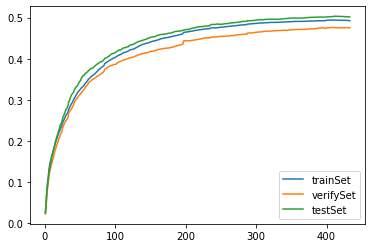

In [12]:
x = [i+1 for i in range(len(accuracy1))]
plt.plot(x, accuracy1, label='trainSet')
plt.plot(x, accuracy2, label='verifySet')
plt.plot(x, accuracy3, label='testSet')
plt.legend(loc='best')
plt.show()